In [1]:
# Import the necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## utils
import time
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


C:\Users\Adam\AppData\Local\Temp\ipykernel_21152\2042845686.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Outline:

- prepare train loader + data augmentation
- definitions and configuaryion of NN
- adding layers
- apply robust techniques (early stopping, regualarization, dropout)

In [3]:
transformTrainAug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainData = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transformTest)
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=64,shuffle=True, num_workers=2)

trainDataAug =  torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transformTrainAug)
trainLoaderAug = torch.utils.data.DataLoader(trainDataAug, batch_size=64,shuffle=True, num_workers=2)

testData = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transformTest)
testLoader = torch.utils.data.DataLoader(testData, batch_size=64, shuffle=False, num_workers=2)

Defnition of 2-3 layered CNNs

In [4]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x



class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

Defining training end evaluation function

In [5]:
def trainModel(nnModel, trainLoader, optimizerMethod=optim.SGD, lossFunction=nn.CrossEntropyLoss(), lRate = 0.005, n_epochs = 10):
    optimizer = optimizerMethod(nnModel.parameters(), lRate, momentum=0.5)

    start = time.time()
    for epch in range(n_epochs): 
        # before each epoch DataLoader reshuffles 
        for idx,dataBatch in enumerate(trainLoader):
            input, labels = dataBatch
            
            # zeroing out the gradient
            optimizer.zero_grad()

            # forward + backward + optimize
            output = nnModel(input)
            loss = lossFunction(output, labels)
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                print(f"Loss: {loss.item():.3f}  Epoch:{epch} Iteration:{idx}")
    
    end = time.time()
    return nnModel, end - start

def evalNN(nnModel, testLoader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            outputs = nnModel(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true += labels.cpu().numpy().tolist()
            y_pred += predicted.cpu().numpy().tolist()

        return y_true, y_pred

### Training and evaluating the NN with 3 layers

In [6]:
trainedNet, meausured_time  = trainModel(Net3(), trainLoader)

Loss: 2.316  Epoch:0 Iteration:0
Loss: 0.620  Epoch:0 Iteration:100
Loss: 0.323  Epoch:0 Iteration:200
Loss: 0.507  Epoch:0 Iteration:300
Loss: 0.341  Epoch:0 Iteration:400
Loss: 0.326  Epoch:0 Iteration:500
Loss: 0.317  Epoch:0 Iteration:600
Loss: 0.430  Epoch:0 Iteration:700
Loss: 0.370  Epoch:0 Iteration:800
Loss: 0.262  Epoch:0 Iteration:900
Loss: 0.266  Epoch:1 Iteration:0
Loss: 0.193  Epoch:1 Iteration:100
Loss: 0.197  Epoch:1 Iteration:200
Loss: 0.232  Epoch:1 Iteration:300
Loss: 0.345  Epoch:1 Iteration:400
Loss: 0.353  Epoch:1 Iteration:500
Loss: 0.416  Epoch:1 Iteration:600
Loss: 0.260  Epoch:1 Iteration:700
Loss: 0.285  Epoch:1 Iteration:800
Loss: 0.255  Epoch:1 Iteration:900
Loss: 0.232  Epoch:2 Iteration:0
Loss: 0.275  Epoch:2 Iteration:100
Loss: 0.277  Epoch:2 Iteration:200
Loss: 0.242  Epoch:2 Iteration:300
Loss: 0.237  Epoch:2 Iteration:400
Loss: 0.167  Epoch:2 Iteration:500
Loss: 0.106  Epoch:2 Iteration:600
Loss: 0.250  Epoch:2 Iteration:700
Loss: 0.259  Epoch:2 Itera

In [7]:
label_true, label_pred = evalNN(trainedNet, testLoader)

Metrics:

In [8]:
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":meausured_time}])

,Accuracy,Precision,Trainig time
0,0.916,0.917159,500.129061


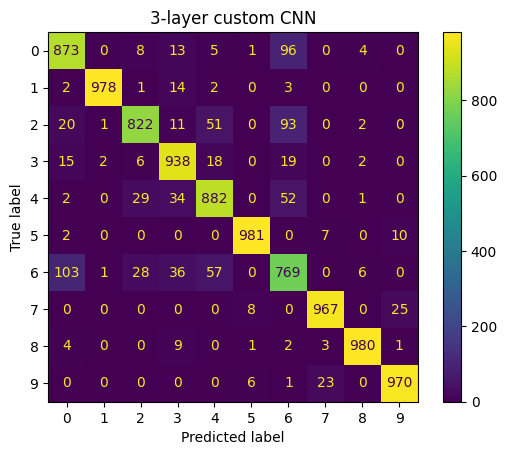

In [9]:
ConfusionMatrixDisplay.from_predictions(label_true, label_pred)
plt.title("3-layer custom CNN")
plt.show()

### Training 2-layered CNN

In [10]:
trainedNet2, timeNet2 = trainModel(Net2(), trainLoader)

Loss: 2.333  Epoch:0 Iteration:0
Loss: 0.696  Epoch:0 Iteration:100
Loss: 0.487  Epoch:0 Iteration:200
Loss: 0.485  Epoch:0 Iteration:300
Loss: 0.462  Epoch:0 Iteration:400
Loss: 0.508  Epoch:0 Iteration:500
Loss: 0.349  Epoch:0 Iteration:600
Loss: 0.232  Epoch:0 Iteration:700
Loss: 0.271  Epoch:0 Iteration:800
Loss: 0.412  Epoch:0 Iteration:900
Loss: 0.404  Epoch:1 Iteration:0
Loss: 0.383  Epoch:1 Iteration:100
Loss: 0.414  Epoch:1 Iteration:200
Loss: 0.222  Epoch:1 Iteration:300
Loss: 0.273  Epoch:1 Iteration:400
Loss: 0.243  Epoch:1 Iteration:500
Loss: 0.286  Epoch:1 Iteration:600
Loss: 0.273  Epoch:1 Iteration:700
Loss: 0.222  Epoch:1 Iteration:800
Loss: 0.317  Epoch:1 Iteration:900
Loss: 0.281  Epoch:2 Iteration:0
Loss: 0.306  Epoch:2 Iteration:100
Loss: 0.155  Epoch:2 Iteration:200
Loss: 0.339  Epoch:2 Iteration:300
Loss: 0.240  Epoch:2 Iteration:400
Loss: 0.241  Epoch:2 Iteration:500
Loss: 0.249  Epoch:2 Iteration:600
Loss: 0.315  Epoch:2 Iteration:700
Loss: 0.225  Epoch:2 Itera

In [11]:
label_true, label_pred = evalNN(trainedNet2, testLoader)
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":timeNet2}])

,Accuracy,Precision,Trainig time
0,0.914,0.91445,359.284058


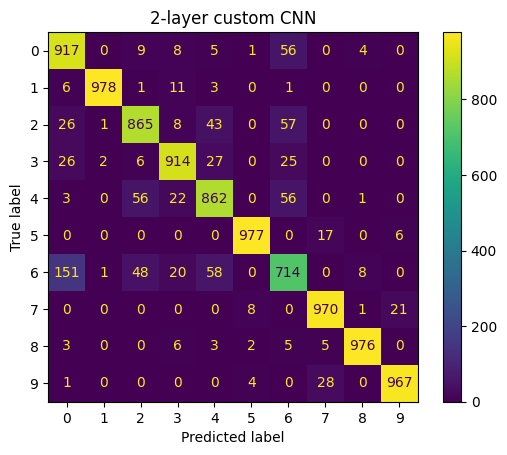

In [12]:
ConfusionMatrixDisplay.from_predictions(label_true, label_pred)
plt.title("2-layer custom CNN")
plt.show()

### Applying Data Augmentation

data was augmented with Random horizontal flipped images and random cropped images

In [13]:
# 2-layered augmented neural network
trainedNetAug2, meausured_timeAug2  = trainModel(Net2(), trainLoaderAug)
label_true, label_pred = evalNN(trainedNetAug2, testLoader)
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":meausured_timeAug2}])

Loss: 2.303  Epoch:0 Iteration:0
Loss: 1.045  Epoch:0 Iteration:100
Loss: 0.898  Epoch:0 Iteration:200
Loss: 0.702  Epoch:0 Iteration:300
Loss: 0.702  Epoch:0 Iteration:400
Loss: 0.553  Epoch:0 Iteration:500
Loss: 0.734  Epoch:0 Iteration:600
Loss: 0.773  Epoch:0 Iteration:700
Loss: 0.404  Epoch:0 Iteration:800
Loss: 0.594  Epoch:0 Iteration:900
Loss: 0.509  Epoch:1 Iteration:0
Loss: 0.648  Epoch:1 Iteration:100
Loss: 0.405  Epoch:1 Iteration:200
Loss: 0.437  Epoch:1 Iteration:300
Loss: 0.393  Epoch:1 Iteration:400
Loss: 0.543  Epoch:1 Iteration:500
Loss: 0.485  Epoch:1 Iteration:600
Loss: 0.681  Epoch:1 Iteration:700
Loss: 0.615  Epoch:1 Iteration:800
Loss: 0.624  Epoch:1 Iteration:900
Loss: 0.487  Epoch:2 Iteration:0
Loss: 0.457  Epoch:2 Iteration:100
Loss: 0.430  Epoch:2 Iteration:200
Loss: 0.594  Epoch:2 Iteration:300
Loss: 0.568  Epoch:2 Iteration:400
Loss: 0.357  Epoch:2 Iteration:500
Loss: 0.549  Epoch:2 Iteration:600
Loss: 0.296  Epoch:2 Iteration:700
Loss: 0.483  Epoch:2 Itera

,Accuracy,Precision,Trainig time
0,0.8843,0.886417,364.500753


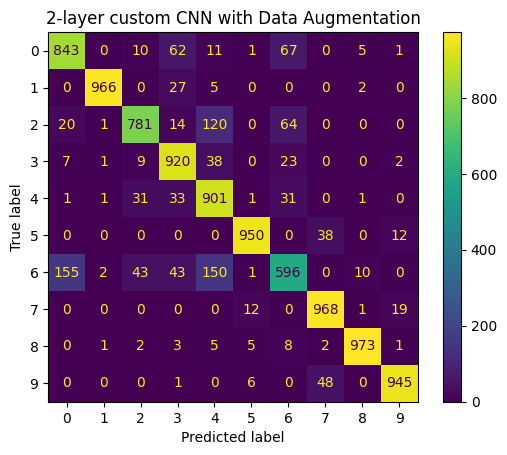

In [14]:
ConfusionMatrixDisplay.from_predictions(label_true, label_pred)
plt.title("2-layer custom CNN with Data Augmentation")
plt.show()

In [15]:
# 3-layered augmented neural network
trainedNetAug3, meausured_timeAug3  = trainModel(Net3(), trainLoaderAug)
label_true, label_pred = evalNN(trainedNetAug3, testLoader)
pd.DataFrame( [{"Accuracy":accuracy_score(label_true, label_pred),
                "Precision":precision_score(label_true, label_pred,average="macro"),
                "Trainig time":meausured_timeAug3}])

Loss: 2.329  Epoch:0 Iteration:0
Loss: 0.944  Epoch:0 Iteration:100
Loss: 0.985  Epoch:0 Iteration:200
Loss: 0.608  Epoch:0 Iteration:300
Loss: 0.650  Epoch:0 Iteration:400
Loss: 0.509  Epoch:0 Iteration:500
Loss: 0.642  Epoch:0 Iteration:600
Loss: 0.560  Epoch:0 Iteration:700
Loss: 0.604  Epoch:0 Iteration:800
Loss: 0.606  Epoch:0 Iteration:900
Loss: 0.549  Epoch:1 Iteration:0
Loss: 0.489  Epoch:1 Iteration:100
Loss: 0.500  Epoch:1 Iteration:200
Loss: 0.520  Epoch:1 Iteration:300
Loss: 0.378  Epoch:1 Iteration:400
Loss: 0.382  Epoch:1 Iteration:500
Loss: 0.446  Epoch:1 Iteration:600
Loss: 0.659  Epoch:1 Iteration:700
Loss: 0.390  Epoch:1 Iteration:800
Loss: 0.617  Epoch:1 Iteration:900
Loss: 0.787  Epoch:2 Iteration:0
Loss: 0.386  Epoch:2 Iteration:100
Loss: 0.461  Epoch:2 Iteration:200
Loss: 0.541  Epoch:2 Iteration:300
Loss: 0.468  Epoch:2 Iteration:400
Loss: 0.559  Epoch:2 Iteration:500
Loss: 0.384  Epoch:2 Iteration:600
Loss: 0.301  Epoch:2 Iteration:700
Loss: 0.266  Epoch:2 Itera

,Accuracy,Precision,Trainig time
0,0.8884,0.888962,510.572935


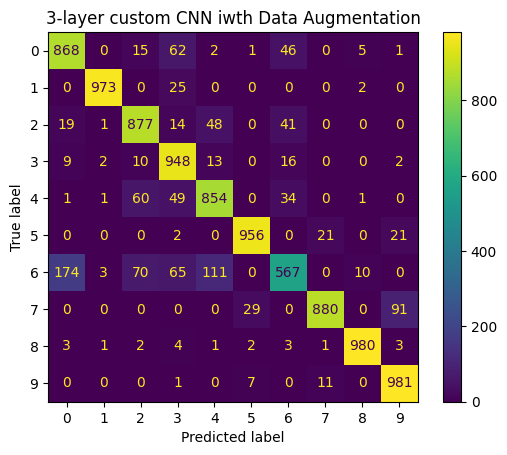

In [16]:
ConfusionMatrixDisplay.from_predictions(label_true, label_pred)
plt.title("3-layer custom CNN iwth Data Augmentation")
plt.show()